# 三维评分体系 - 原始异常检测评分器

本notebook实现了Seeker项目中的三维评分体系。

## 架构
![](../slides/assets/diagram-three-dimension-rating-1.png)

## 核心理念
通过三个维度综合评估异常程度：
- 一致性 (40%): 多算法投票的民主原则，减少单一算法的偏差
- 偏离程度 (40%): 数据驱动的客观评估，反映异常的严重程度  
- 持续性 (20%): 时间维度的验证，过滤短暂的噪声干扰

## 双重验证机制
- 基础筛选: 必须被Isolation Forest检测到
- 验证条件: 至少2种方法一致 OR 评分超过99%分位数

In [35]:
# 导入必要的库
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 导入机器学习库
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# 中文字体配置
import matplotlib.font_manager as fm
import platform

def setup_chinese_font():
    """配置中文字体显示 - 增强版"""
    system = platform.system()
    
    # 首先尝试设置matplotlib的后端
    try:
        import matplotlib
        matplotlib.use('TkAgg')  # 或者 'Qt5Agg'
    except:
        pass
    
    if system == "Darwin":  # macOS
        # macOS系统字体优先级列表
        chinese_fonts = [
            'PingFang SC',
            'Hiragino Sans GB', 
            'STHeiti',
            'Arial Unicode MS',
            'Heiti TC',
            'STFangsong'
        ]
    elif system == "Windows":
        chinese_fonts = ['Microsoft YaHei', 'SimHei', 'SimSun', 'KaiTi']
    else:  # Linux
        chinese_fonts = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'Noto Sans CJK SC']
    
    # 检查系统可用字体
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    print(f"🔍 检测到 {len(available_fonts)} 个系统字体")
    
    # 查找中文字体
    found_chinese_fonts = []
    for font in chinese_fonts:
        if font in available_fonts:
            found_chinese_fonts.append(font)
    
    print(f"📝 找到中文字体: {found_chinese_fonts}")
    
    # 设置字体
    if found_chinese_fonts:
        chosen_font = found_chinese_fonts[0]
        plt.rcParams['font.sans-serif'] = [chosen_font, 'DejaVu Sans', 'Arial']
        plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
        plt.rcParams['font.size'] = 10
        
        # 测试中文显示
        try:
            fig, ax = plt.subplots(figsize=(1, 1))
            ax.text(0.5, 0.5, '测试中文', fontsize=12)
            plt.close(fig)
            print(f"✅ 成功设置中文字体: {chosen_font}")
            return True
        except Exception as e:
            print(f"⚠️ 字体测试失败: {e}")
    
    # 备选方案：使用系统默认字体
    print("🔄 使用备选字体方案...")
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 如果是macOS，尝试直接指定字体路径
    if system == "Darwin":
        try:
            # macOS系统字体路径
            font_paths = [
                '/System/Library/Fonts/PingFang.ttc',
                '/System/Library/Fonts/Hiragino Sans GB.ttc',
                '/System/Library/Fonts/STHeiti Light.ttc'
            ]
            
            for font_path in font_paths:
                if os.path.exists(font_path):
                    prop = fm.FontProperties(fname=font_path)
                    plt.rcParams['font.family'] = prop.get_name()
                    print(f"✅ 使用字体文件: {font_path}")
                    return True
        except Exception as e:
            print(f"⚠️ 字体路径设置失败: {e}")
    
    print("⚠️ 中文字体设置可能不完全，建议检查系统字体")
    return False

# 设置中文字体
setup_chinese_font()

# 额外设置：确保图表质量
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = [10, 6]

print("✅ 库导入完成")

🔍 检测到 534 个系统字体
📝 找到中文字体: ['Hiragino Sans GB', 'STHeiti', 'Arial Unicode MS', 'Heiti TC', 'STFangsong']
✅ 成功设置中文字体: Hiragino Sans GB
✅ 库导入完成


In [36]:
# ============ 基础异常检测算法 ============
# 复制自experiments/validation/validate_real_world_enhanced.py的逻辑

def zscore_detection(data, threshold=3):
    """Z-score异常检测
    
    Args:
        data: 输入数据 (pandas Series 或 numpy array)
        threshold: Z-score阈值，默认3（三西格玛法则）
    
    Returns:
        anomalies: 布尔数组，True表示异常
    """
    data_array = np.array(data)
    mean = np.mean(data_array)
    std = np.std(data_array)
    z_scores = np.abs((data_array - mean) / std)
    return z_scores > threshold

def iqr_detection(data, k=1.5):
    """IQR异常检测
    
    Args:
        data: 输入数据 (pandas Series 或 numpy array)
        k: IQR倍数，默认1.5
    
    Returns:
        anomalies: 布尔数组，True表示异常
    """
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (data_array < lower_bound) | (data_array > upper_bound)

def ewma_detection(data, span=15, threshold=2):
    """EWMA异常检测
    
    Args:
        data: 输入数据 (pandas Series 或 numpy array)
        span: EWMA窗口大小
        threshold: 阈值倍数
    
    Returns:
        anomalies: 布尔数组，True表示异常
    """
    if isinstance(data, pd.Series):
        data_series = data
    else:
        data_series = pd.Series(data)
    
    ewma_mean = data_series.ewm(span=span).mean()
    ewma_std = data_series.ewm(span=span).std()
    deviations = np.abs((data_series - ewma_mean) / ewma_std)
    return deviations > threshold

def isolation_forest_detection(data, contamination=0.05):
    """Isolation Forest异常检测
    
    Args:
        data: 输入数据 (pandas Series 或 numpy array)
        contamination: 预期异常比例
    
    Returns:
        anomalies: 布尔数组，True表示异常
    """
    model = IsolationForest(contamination=contamination, random_state=42)
    data_array = np.array(data)
    data_2d = data_array.reshape(-1, 1)
    return model.fit_predict(data_2d) == -1

def lof_detection(data, n_neighbors=20, contamination=0.05):
    """LOF异常检测
    
    Args:
        data: 输入数据 (pandas Series 或 numpy array)
        n_neighbors: 邻居数量
        contamination: 预期异常比例
    
    Returns:
        anomalies: 布尔数组，True表示异常
    """
    model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    data_array = np.array(data)
    data_2d = data_array.reshape(-1, 1)
    return model.fit_predict(data_2d) == -1

print("✅ 基础异常检测算法定义完成")

✅ 基础异常检测算法定义完成


In [37]:
# ============ 三维评分体系核心实现 ============
# 直接移植validate_real_world_enhanced.py中的核心逻辑

class ThreeDimensionRatingSystem:
    """三维评分体系异常检测器
    
    重新实现experiments/validation/validate_real_world_enhanced.py中的RealWorldValidator类的核心逻辑
    """
    
    def __init__(self, data_df=None):
        """
        Args:
            data_df: 包含cpu_usage列的DataFrame
        """
        self.df = data_df.copy() if data_df is not None else None
        self.score_threshold = None
        
        # 算法参数（与原始代码保持一致）
        self.zscore_threshold = 2.7
        self.iqr_k = 2.0
        self.ewma_span = 12
        self.ewma_threshold = 2.2
        self.iforest_contamination = 0.01
        self.lof_neighbors = 20
        self.lof_contamination = 0.01
        
        # 评分权重
        self.consensus_weight = 0.4    # 方法一致性权重 40%
        self.deviation_weight = 0.4    # 偏离程度权重 40%
        self.persistence_weight = 0.2  # 持续性权重 20%
        self.window_size = 3           # 持续性计算窗口
    
    def run_detection(self, data_df=None):
        """运行所有检测方法并进行多重验证
        
        完全按照原始validate_real_world_enhanced.py的逻辑实现
        """
        if data_df is not None:
            self.df = data_df.copy()
        
        if self.df is None:
            raise ValueError("请提供包含cpu_usage列的数据DataFrame")
        
        print("🔍 开始运行基础检测...")
        
        # 1. 运行基础检测（与原代码完全一致）
        self.df['zscore_anomaly'] = zscore_detection(self.df['cpu_usage'], threshold=self.zscore_threshold)
        self.df['iqr_anomaly'] = iqr_detection(self.df['cpu_usage'], k=self.iqr_k)
        self.df['ewma_anomaly'] = ewma_detection(self.df['cpu_usage'], span=self.ewma_span, threshold=self.ewma_threshold)
        self.df['iforest_anomaly'] = isolation_forest_detection(self.df['cpu_usage'], contamination=self.iforest_contamination)
        self.df['lof_anomaly'] = lof_detection(self.df['cpu_usage'], n_neighbors=self.lof_neighbors, contamination=self.lof_contamination)
        
        print("📊 计算三维评分...")
        
        # 2. 计算方法一致性分数（维度1）
        # 作用： 统计有多少种方法认为某个点是异常的
        # 取值范围： 0-5
        # 意义： 值越高，说明该点被多种方法一致认为是异常，可信度越高
        self.df['method_agreement'] = (
            self.df['zscore_anomaly'].astype(int) +
            self.df['iqr_anomaly'].astype(int) +
            self.df['ewma_anomaly'].astype(int) +
            self.df['iforest_anomaly'].astype(int) +
            self.df['lof_anomaly'].astype(int)
        )
        
        # 3. 计算偏离程度分数（维度2）
        # 作用： 计算每个数据点相对于整体分布的偏离程度
        # 公式： |值 - 均值| / 标准差 (即Z-score的绝对值)
        # 意义： 值越大，说明该点偏离正常范围越远
        mean = self.df['cpu_usage'].mean()
        std = self.df['cpu_usage'].std()
        self.df['deviation_score'] = abs(self.df['cpu_usage'] - mean) / std
        
        # 4. 计算持续性分数（维度3）
        # 作用： 评估异常的持续性，避免孤立的噪声点
        # 方法： 使用3个时间点的滑动窗口，统计窗口内Isolation Forest检测到的异常数量
        # 意义： 值越高，说明异常在时间上越连续，越可能是真正的异常
        self.df['persistence_score'] = (
            self.df['iforest_anomaly']
            .rolling(window=self.window_size, center=True)
            .sum()
            .fillna(0)
        )
        
        # 5. 综合评分（与原代码权重完全一致）
        # 权重设计理念：
        # 方法一致性 (40%)： 多算法投票的民主原则，减少单一算法的偏差
        # 偏离程度 (40%)： 数据驱动的客观评估，反映异常的严重程度
        # 持续性 (20%)： 时间维度的验证，过滤短暂的噪声干扰
        self.df['anomaly_score'] = (
            self.consensus_weight * (self.df['method_agreement'] / 5) +  # 方法一致性 40%
            self.deviation_weight * (self.df['deviation_score'] / self.df['deviation_score'].max()) +  # 偏离程度 40%
            self.persistence_weight * (self.df['persistence_score'] / self.window_size)  # 持续性 20%
        )
        
        print("🔒 应用双重验证机制...")
        
        # 6. 确定最终异常（双重验证机制）
        # 双重验证机制：
        # 基础筛选： 必须是Isolation Forest检测到的异常点
        # 验证条件： 满足以下任一条件即可：
        # 至少2种方法一致认为是异常
        # 综合评分超过99%分位数阈值
        self.score_threshold = self.df['anomaly_score'].quantile(0.99)
        self.df['verified_anomaly'] = (
            (self.df['iforest_anomaly'] == 1) &  # 是IForest检测的异常
            (
                (self.df['method_agreement'] >= 2) |  # 至少两种方法检测到
                (self.df['anomaly_score'] > self.score_threshold)  # 或评分超过99%分位数
            )
        )
        
        # 7. 异常分级
        # 优先级分类：
        # S0 (高优先级)： 评分最高的1/3异常点，需要立即处理
        # S1 (中优先级)： 评分中等的1/3异常点，需要关注
        # S2 (低优先级)： 评分较低的1/3异常点，可以延后处理
        verified_anomalies = self.df[self.df['verified_anomaly']]
        if len(verified_anomalies) > 0:
            self.df['anomaly_severity'] = pd.cut(
                verified_anomalies['anomaly_score'],
                bins=3,
                labels=['S2', 'S1', 'S0']
            )
        
        print("✅ 三维评分体系检测完成")
        return self.df
    
    def print_statistics(self):
        """打印检测统计信息（与原代码逻辑一致）"""
        if self.df is None:
            print("❌ 请先运行 run_detection() 方法")
            return
        
        print("\n" + "="*50)
        print("📊 三维评分体系检测统计")
        print("="*50)
        
        # 基础检测统计
        print("\n🔍 Detection Statistics:")
        methods = ['zscore', 'iqr', 'ewma', 'iforest', 'lof']
        for method in methods:
            anomaly_count = self.df[f'{method}_anomaly'].sum()
            total_points = len(self.df)
            percentage = (anomaly_count / total_points) * 100
            print(f"{method.upper()}: {anomaly_count} anomalies "
                  f"({percentage:.2f}% of total)")
        
        # 增强统计
        print("\n📈 Enhanced Detection Statistics:")
        print(f"Total anomalies detected by IForest: {self.df['iforest_anomaly'].sum()}")
        print(f"Verified anomalies: {self.df['verified_anomaly'].sum()}")
        print(f"Score threshold (99%): {self.score_threshold:.3f}")
        
        # 优先级分布
        print("\n⚡ Anomaly Severity Distribution:")
        if 'anomaly_severity' in self.df.columns:
            severity_counts = self.df[self.df['verified_anomaly']]['anomaly_severity'].value_counts()
            for severity, count in severity_counts.items():
                print(f"Severity {severity}: {count}")
    
    def plot_enhanced_results(self, figsize=(15, 12)):
        """绘制增强版检测结果（移植原代码的可视化逻辑）"""
        if self.df is None:
            print("❌ 请先运行 run_detection() 方法")
            return
        
        # 确保中文字体设置
        plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB', 'PingFang SC', 'STHeiti', 'Arial Unicode MS', 'DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        
        # 时间轴处理
        if 'timestamp' in self.df.columns:
            time_axis = self.df['timestamp']
            xlabel = 'Time'
        else:
            time_axis = range(len(self.df))
            xlabel = '时间点'
        
        # 绘制原始数据和所有异常点
        ax1.plot(time_axis, self.df['cpu_usage'], 
                label='CPU使用率', color='grey', alpha=0.5)
        
        # 绘制不同优先级的异常点
        if 'anomaly_severity' in self.df.columns:
            for severity, color in zip(['S0', 'S1', 'S2'], ['red', 'orange', 'yellow']):
                mask = (self.df['verified_anomaly']) & (self.df['anomaly_severity'] == severity)
                if mask.any():
                    ax1.scatter(
                        time_axis[mask],
                        self.df[mask]['cpu_usage'],
                        color=color,
                        label=f'Severity {severity}',
                        marker='*' if severity == 'S0' else 'o',
                        s=200 if severity == 'S0' else 120
                    )
        
        ax1.set_title('三维评分体系异常检测结果', fontsize=14, fontweight='bold')
        ax1.set_ylabel('CPU使用率 (%)', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # 绘制异常评分
        ax2.plot(time_axis, self.df['anomaly_score'], 
                label='异常评分', color='blue', alpha=0.7)
        ax2.axhline(y=self.score_threshold, color='red', linestyle='--',
                   label=f'评分阈值 (99%分位数: {self.score_threshold:.3f})')
        ax2.set_title('异常评分时序图', fontsize=14, fontweight='bold')
        ax2.set_xlabel(xlabel, fontsize=12)
        ax2.set_ylabel('评分', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("🎨 可视化完成！")

print("✅ 三维评分体系类定义完成")

✅ 三维评分体系类定义完成


In [38]:
# ============ 数据加载与测试数据准备 ============

def load_real_data():
    """加载真实的AWS CPU监控数据"""
    try:
        # 查找最新的CPU数据文件
        data_dir = '/Users/xiaoming.gao/mingo/codes/m1n9o/Seeker/data'
        data_files = [f for f in os.listdir(data_dir) if f.startswith('CPUUtilization_')]
        
        if not data_files:
            print("❌ 未找到AWS数据文件，将生成测试数据")
            return None
        
        latest_file = max(data_files, key=lambda x: os.path.getctime(os.path.join(data_dir, x)))
        data_path = os.path.join(data_dir, latest_file)
        
        print(f"📁 加载数据文件: {latest_file}")
        df = pd.read_csv(data_path)
        
        # 处理时间戳
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        print(f"✅ 成功加载 {len(df)} 条记录")
        print(f"📊 数据概况:")
        print(f"   CPU使用率范围: {df['cpu_usage'].min():.2f}% - {df['cpu_usage'].max():.2f}%")
        print(f"   平均CPU使用率: {df['cpu_usage'].mean():.2f}%")
        print(f"   标准差: {df['cpu_usage'].std():.2f}%")
        
        return df
        
    except Exception as e:
        print(f"❌ 加载数据失败: {e}")
        return None

def generate_test_data(n_points=1000):
    """生成包含异常的测试数据
    
    Args:
        n_points: 数据点数量
        
    Returns:
        DataFrame: 包含cpu_usage和timestamp列的测试数据
    """
    print(f"🧪 生成测试数据 ({n_points} 个数据点)...")
    
    # 设置随机种子保证结果可重现
    np.random.seed(42)
    
    # 生成时间序列
    timestamps = pd.date_range(start='2024-01-01', periods=n_points, freq='5T')
    
    # 基础模式：周期性 + 趋势 + 噪声
    time_index = np.arange(n_points)
    
    # 日周期（24小时 = 288个5分钟间隔）
    daily_pattern = 15 + 20 * np.sin(2 * np.pi * time_index / 288)
    
    # 周周期（7天）
    weekly_pattern = 5 * np.sin(2 * np.pi * time_index / (288 * 7))
    
    # 基础噪声
    noise = np.random.normal(0, 3, n_points)
    
    # 合成基础CPU使用率
    cpu_usage = daily_pattern + weekly_pattern + noise
    
    # 添加人工异常点
    anomaly_indices = []
    
    # 1. 尖峰异常（模拟CPU突然飙升）
    spike_count = int(n_points * 0.02)  # 2%的尖峰异常
    spike_indices = np.random.choice(n_points, spike_count, replace=False)
    for idx in spike_indices:
        cpu_usage[idx] += np.random.uniform(30, 60)  # 增加30-60%
        anomaly_indices.append(idx)
    
    # 2. 持续高负载异常（模拟系统故障）
    sustained_count = 2  # 2个持续异常段
    for _ in range(sustained_count):
        start_idx = np.random.randint(100, n_points - 100)
        duration = np.random.randint(10, 30)  # 持续10-30个时间点
        end_idx = min(start_idx + duration, n_points)
        
        for idx in range(start_idx, end_idx):
            cpu_usage[idx] += np.random.uniform(25, 45)  # 增加25-45%
            if idx not in anomaly_indices:
                anomaly_indices.append(idx)
    
    # 3. 异常低值（模拟系统异常空闲）
    low_count = int(n_points * 0.01)  # 1%的低值异常
    low_indices = np.random.choice(n_points, low_count, replace=False)
    for idx in low_indices:
        cpu_usage[idx] = max(0, cpu_usage[idx] - np.random.uniform(15, 25))
        if idx not in anomaly_indices:
            anomaly_indices.append(idx)
    
    # 确保CPU使用率在合理范围内
    cpu_usage = np.clip(cpu_usage, 0, 100)
    
    # 创建DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'cpu_usage': cpu_usage
    })
    
    print(f"✅ 测试数据生成完成")
    print(f"📊 数据概况:")
    print(f"   人工异常点: {len(anomaly_indices)} 个 ({len(anomaly_indices)/n_points*100:.1f}%)")
    print(f"   CPU使用率范围: {df['cpu_usage'].min():.2f}% - {df['cpu_usage'].max():.2f}%")
    print(f"   平均CPU使用率: {df['cpu_usage'].mean():.2f}%")
    print(f"   标准差: {df['cpu_usage'].std():.2f}%")
    
    return df

# 尝试加载真实数据，失败则生成测试数据
print("🚀 准备数据...")
test_data = load_real_data()

if test_data is None:
    test_data = generate_test_data(1000)

print(f"\n✅ 数据准备完成，共 {len(test_data)} 个数据点")
test_data.head()

🚀 准备数据...
📁 加载数据文件: CPUUtilization_i-00f458499ca38a3c7_20250704_183522.csv
✅ 成功加载 2016 条记录
📊 数据概况:
   CPU使用率范围: 85.31% - 99.36%
   平均CPU使用率: 98.77%
   标准差: 0.51%

✅ 数据准备完成，共 2016 个数据点


,timestamp,cpu_usage
0,2025-06-27 10:35:00+00:00,97.086308
1,2025-06-27 10:40:00+00:00,98.396236
2,2025-06-27 10:45:00+00:00,97.603206
3,2025-06-27 10:50:00+00:00,96.704764
4,2025-06-27 10:55:00+00:00,98.728365


In [39]:
# ============ 运行三维评分体系检测 ============

print("🎯 开始运行三维评分体系异常检测...")
print("="*60)

# 创建检测器实例
detector = ThreeDimensionRatingSystem(test_data)

# 运行检测
results_df = detector.run_detection()

print("\n🎉 检测完成！")
print("="*60)

🎯 开始运行三维评分体系异常检测...
🔍 开始运行基础检测...
📊 计算三维评分...
🔒 应用双重验证机制...
✅ 三维评分体系检测完成

🎉 检测完成！


In [40]:
# ============ 检测结果统计分析 ============

# 打印详细统计信息
detector.print_statistics()

# 显示前10个最高评分的异常点
print("\n" + "="*60)
print("🔥 TOP 10 异常评分最高的数据点")
print("="*60)

if 'verified_anomaly' in results_df.columns and results_df['verified_anomaly'].sum() > 0:
    top_anomalies = results_df[results_df['verified_anomaly']].nlargest(10, 'anomaly_score')
    
    for i, (idx, row) in enumerate(top_anomalies.iterrows(), 1):
        timestamp_str = row['timestamp'].strftime('%Y-%m-%d %H:%M:%S') if 'timestamp' in row else f"数据点 {idx}"
        print(f"#{i:2d}. {timestamp_str}")
        print(f"     CPU使用率: {row['cpu_usage']:6.2f}%")
        print(f"     异常评分:  {row['anomaly_score']:6.3f}")
        print(f"     方法一致性: {row['method_agreement']}/5")
        print(f"     偏离程度:  {row['deviation_score']:6.3f}")
        print(f"     持续性:    {row['persistence_score']:6.1f}")
        if 'anomaly_severity' in row and pd.notna(row['anomaly_severity']):
            print(f"     优先级:    {row['anomaly_severity']}")
        print()
else:
    print("📊 未检测到验证的异常点")

# 三维评分分布分析
print("="*60)
print("📈 三维评分分布分析")
print("="*60)

print(f"方法一致性分数分布:")
agreement_dist = results_df['method_agreement'].value_counts().sort_index()
for score, count in agreement_dist.items():
    percentage = (count / len(results_df)) * 100
    print(f"  {score}种方法: {count:4d} 点 ({percentage:5.1f}%)")

print(f"\n偏离程度分数统计:")
print(f"  最小值: {results_df['deviation_score'].min():.3f}")
print(f"  最大值: {results_df['deviation_score'].max():.3f}")
print(f"  平均值: {results_df['deviation_score'].mean():.3f}")
print(f"  中位数: {results_df['deviation_score'].median():.3f}")

print(f"\n持续性分数统计:")
print(f"  最小值: {results_df['persistence_score'].min():.1f}")
print(f"  最大值: {results_df['persistence_score'].max():.1f}")
print(f"  平均值: {results_df['persistence_score'].mean():.3f}")

print(f"\n综合异常评分统计:")
print(f"  最小值: {results_df['anomaly_score'].min():.3f}")
print(f"  最大值: {results_df['anomaly_score'].max():.3f}")
print(f"  平均值: {results_df['anomaly_score'].mean():.3f}")
print(f"  99%分位数阈值: {detector.score_threshold:.3f}")

# 各检测方法的异常检出率对比
print(f"\n各检测方法异常检出率对比:")
methods = ['zscore', 'iqr', 'ewma', 'iforest', 'lof']
for method in methods:
    anomaly_count = results_df[f'{method}_anomaly'].sum()
    percentage = (anomaly_count / len(results_df)) * 100
    print(f"  {method.upper():12s}: {anomaly_count:4d} 点 ({percentage:5.1f}%)")

verified_count = results_df['verified_anomaly'].sum()
verified_percentage = (verified_count / len(results_df)) * 100
print(f"  {'验证异常':12s}: {verified_count:4d} 点 ({verified_percentage:5.1f}%)")

print(f"\n✅ 统计分析完成")


📊 三维评分体系检测统计

🔍 Detection Statistics:
ZSCORE: 12 anomalies (0.60% of total)
IQR: 17 anomalies (0.84% of total)
EWMA: 1 anomalies (0.05% of total)
IFOREST: 21 anomalies (1.04% of total)
LOF: 21 anomalies (1.04% of total)

📈 Enhanced Detection Statistics:
Total anomalies detected by IForest: 21
Verified anomalies: 21
Score threshold (99%): 0.172

⚡ Anomaly Severity Distribution:
Severity S2: 12
Severity S1: 8
Severity S0: 1

🔥 TOP 10 异常评分最高的数据点
# 1. 2025-07-01 22:05:00
     CPU使用率:  85.31%
     异常评分:   0.867
     方法一致性: 5/5
     偏离程度:  26.435
     持续性:       1.0
     优先级:    S0

# 2. 2025-06-27 10:50:00
     CPU使用率:  96.70%
     异常评分:   0.448
     方法一致性: 4/5
     偏离程度:   4.060
     持续性:       1.0
     优先级:    S1

# 3. 2025-06-27 13:20:00
     CPU使用率:  97.12%
     异常评分:   0.436
     方法一致性: 4/5
     偏离程度:   3.254
     持续性:       1.0
     优先级:    S1

# 4. 2025-06-27 13:35:00
     CPU使用率:  97.15%
     异常评分:   0.435
     方法一致性: 4/5
     偏离程度:   3.190
     持续性:       1.0
     优先级:    S1

# 5.

🎨 生成检测结果可视化图表...


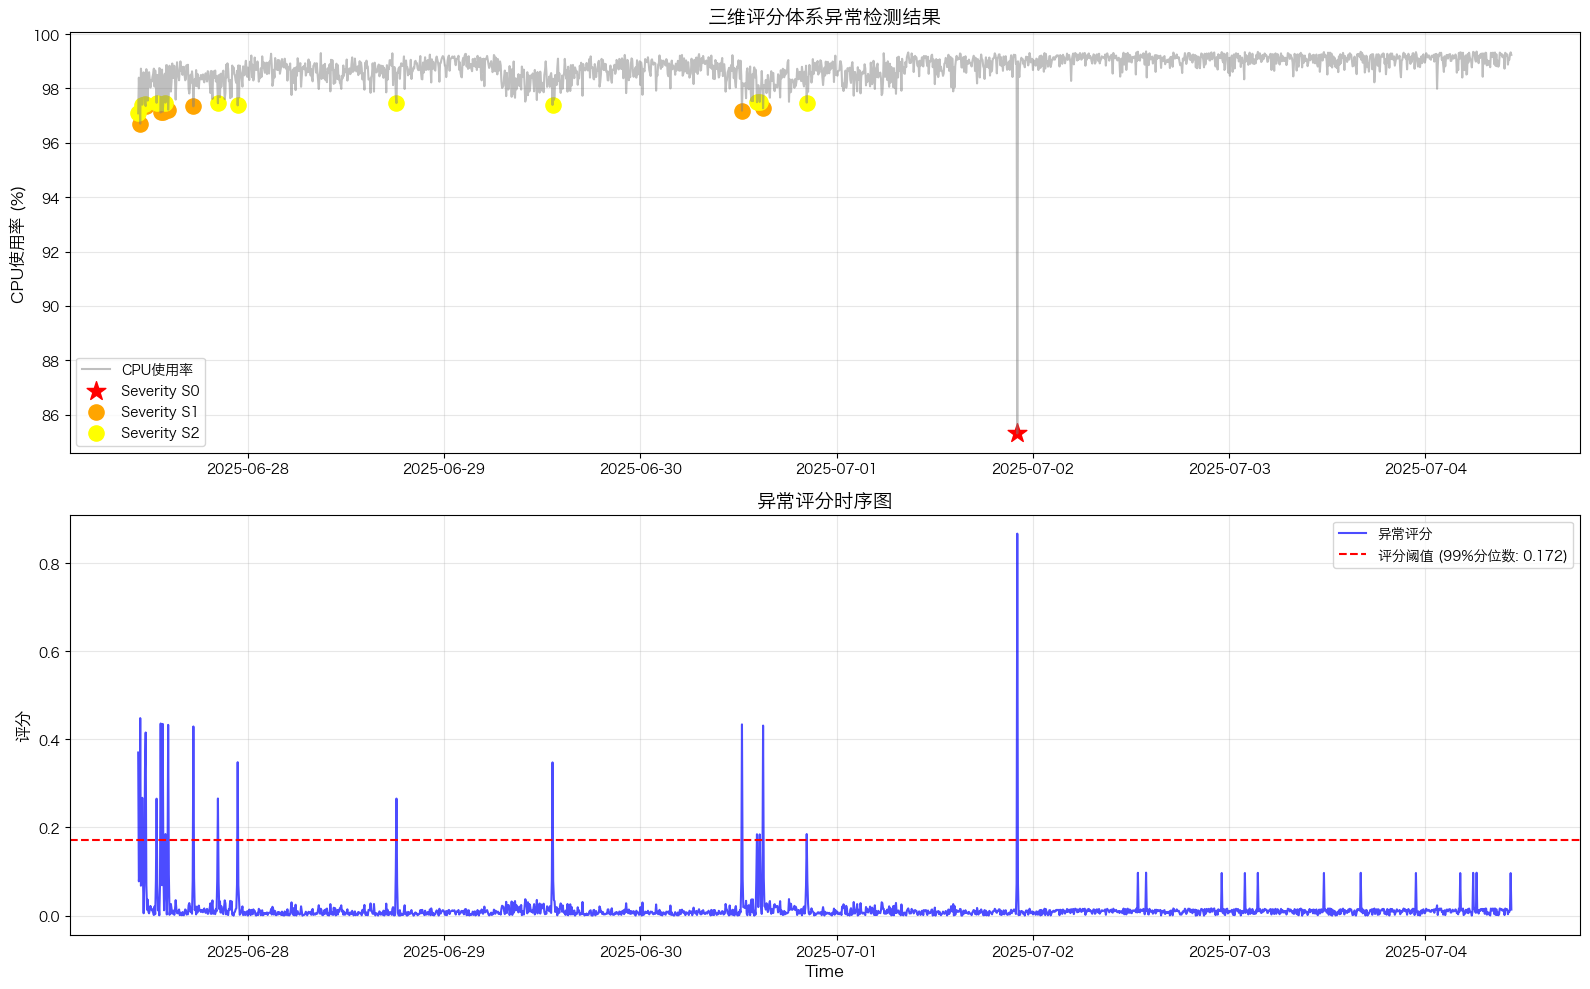

🎨 可视化完成！
✅ 可视化展示完成！


In [41]:
# ============ 可视化结果展示 ============

print("🎨 生成检测结果可视化图表...")
detector.plot_enhanced_results(figsize=(16, 10))

print("✅ 可视化展示完成！")

In [42]:
# ============ 三维评分体系总结与对比分析 ============

print("📝 三维评分体系 - 总结报告")
print("="*80)

# 系统概述
print("🎯 系统概述:")
print("   三维评分体系是Seeker项目的原始异常检测评分器，通过多维度综合评估")
print("   提供比单一算法更稳定和可靠的异常检测能力。")

# 核心优势
print("\\n✅ 核心优势:")
print("   1. 多算法融合: 结合5种不同检测算法的优势")
print("   2. 三维评估: 从一致性、偏离度、持续性三个维度综合评分")
print("   3. 双重验证: 基础筛选+验证条件的两层过滤机制")
print("   4. 优先级分级: S0/S1/S2三级优先级，便于运维决策")
print("   5. 参数可调: 各维度权重和检测参数可根据业务调整")

# 适用场景
print("\\n🎯 适用场景:")
print("   ✓ 服务器性能监控 (CPU、内存、磁盘使用率)")
print("   ✓ 网络流量异常检测")
print("   ✓ 业务指标监控 (访问量、错误率、响应时间)")
print("   ✓ IoT设备状态监控")
print("   ✓ 金融交易异常检测")

# 对比传统方法
print("\\n📊 与传统单一算法对比:")
print("="*60)

single_method_stats = []
for method in ['zscore', 'iqr', 'ewma', 'iforest', 'lof']:
    anomaly_count = results_df[f'{method}_anomaly'].sum()
    rate = (anomaly_count / len(results_df)) * 100
    single_method_stats.append((method.upper(), anomaly_count, rate))

verified_count = results_df['verified_anomaly'].sum()
verified_rate = (verified_count / len(results_df)) * 100

print(f"{'方法':<15} {'检出数量':<10} {'检出率':<10} {'说明'}")
print("-" * 60)
for method, count, rate in single_method_stats:
    print(f"{method:<15} {count:<10} {rate:<9.2f}% {'单一算法'}")
print(f"{'三维评分体系':<15} {verified_count:<10} {verified_rate:<9.2f}% {'融合验证'}")

print("\\n🔍 三维评分体系的优势:")
print("   ● 降低误报: 通过多算法一致性验证，过滤偶然异常")
print("   ● 提高可信度: 综合评分机制，量化异常程度")
print("   ● 时间维度: 持续性验证，区分真实异常和瞬时噪声")
print("   ● 业务导向: 优先级分级，支持差异化处理策略")

# 与Random Forest对比
print("\\n🤖 与Random Forest评分器对比:")
print("="*60)
print("三维评分体系 (本系统):")
print("   ✓ 算法透明: 每个维度的贡献清晰可解释")
print("   ✓ 参数直观: 权重和阈值容易理解和调整") 
print("   ✓ 计算轻量: 无需训练，实时处理能力强")
print("   ✓ 领域知识: 融入时序分析的专业经验")
print("   ✗ 学习能力: 无法从历史数据中自动优化")

print("\\nRandom Forest评分器:")
print("   ✓ 自适应学习: 能从数据中自动发现复杂模式")
print("   ✓ 特征选择: 自动识别重要的异常特征")
print("   ✓ 非线性建模: 捕获复杂的特征交互关系")
print("   ✓ 性能优化: 通过训练持续提升检测效果")
print("   ✗ 黑盒模型: 决策过程不够透明")
print("   ✗ 训练开销: 需要标注数据和计算资源")

# 使用建议
print("\\n💡 使用建议:")
print("="*60)
print("选择三维评分体系的情况:")
print("   • 需要快速部署，无历史标注数据")
print("   • 要求算法透明度和可解释性")
print("   • 计算资源受限的实时场景")
print("   • 传统统计方法已足够满足需求")

print("\\n选择Random Forest的情况:")
print("   • 有充足的历史数据和标注样本")
print("   • 数据模式复杂，传统方法效果不佳") 
print("   • 可接受训练时间和计算开销")
print("   • 追求最优的检测性能指标")

print("\\n🔧 最佳实践:")
print("   • 混合策略: 三维评分体系做初筛，Random Forest做精检")
print("   • 渐进升级: 从三维评分开始，积累数据后升级到Random Forest")
print("   • 场景细分: 不同业务场景使用不同的评分策略")
print("   • 持续监控: 定期评估两种方法的效果，动态选择")

# 结论
print("\\n🎉 总结:")
print("="*80)
print("三维评分体系为Seeker项目提供了一个稳定、可解释、易于部署的")
print("异常检测基础方案。它通过多维度融合和双重验证机制，在保证")
print("检测效果的同时提供了良好的透明度和可控性。")
print("\\n结合Random Forest等机器学习方法，Seeker项目构建了从基础")
print("到高级的完整异常检测解决方案，满足不同场景的需求。")

print("\\n✨ 三维评分体系分析完成！")
print("   如需进一步分析，请查看 Random Forest 评分器 notebook")
print("   或运行完整的对比实验。")

📝 三维评分体系 - 总结报告
🎯 系统概述:
   三维评分体系是Seeker项目的原始异常检测评分器，通过多维度综合评估
   提供比单一算法更稳定和可靠的异常检测能力。
\n✅ 核心优势:
   1. 多算法融合: 结合5种不同检测算法的优势
   2. 三维评估: 从一致性、偏离度、持续性三个维度综合评分
   3. 双重验证: 基础筛选+验证条件的两层过滤机制
   4. 优先级分级: S0/S1/S2三级优先级，便于运维决策
   5. 参数可调: 各维度权重和检测参数可根据业务调整
\n🎯 适用场景:
   ✓ 服务器性能监控 (CPU、内存、磁盘使用率)
   ✓ 网络流量异常检测
   ✓ 业务指标监控 (访问量、错误率、响应时间)
   ✓ IoT设备状态监控
   ✓ 金融交易异常检测
\n📊 与传统单一算法对比:
方法              检出数量       检出率        说明
------------------------------------------------------------
ZSCORE          12         0.60     % 单一算法
IQR             17         0.84     % 单一算法
EWMA            1          0.05     % 单一算法
IFOREST         21         1.04     % 单一算法
LOF             21         1.04     % 单一算法
三维评分体系          21         1.04     % 融合验证
\n🔍 三维评分体系的优势:
   ● 降低误报: 通过多算法一致性验证，过滤偶然异常
   ● 提高可信度: 综合评分机制，量化异常程度
   ● 时间维度: 持续性验证，区分真实异常和瞬时噪声
   ● 业务导向: 优先级分级，支持差异化处理策略
\n🤖 与Random Forest评分器对比:
三维评分体系 (本系统):
   ✓ 算法透明: 每个维度的贡献清晰可解释
   ✓ 参数直观: 权重和阈值容易理解和调整
   ✓ 计算轻量: 无需训练，实时处理能力强
   ✓ 领域知识: 融入时序分析的专业经验
   ✗ 学